In [47]:
import pandas as pd
import pickle
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import numpy as np

In [3]:
with open(
    os.path.dirname(os.getcwd()) + "/model_data/oceanography_data_ave.pkl", "rb"
) as file:
    oceanography_data = pickle.load(file)

In [74]:
with open(
    os.path.dirname(os.getcwd()) + "/model_data/target_data_prototype.pkl", "rb"
) as file:
    target_data = pickle.load(file)

In [30]:
def aggregate_data(ocean, target, areas=[41, 61, 81], scale=False):
    aggregated = pd.DataFrame()

    for area in areas:
        temp = ocean[area].copy()
        temp["Area"] = [area] * len(temp)
        if scale:
            vars = [var for var in temp.columns if var not in ["Year", "Area"]]
            sc = StandardScaler()
            X = sc.fit_transform(temp[vars])
            temp = pd.concat(
                [temp[["Year", "Area"]], pd.DataFrame(X, columns=vars)], axis=1
            )
        if aggregated.empty:
            aggregated = temp
        else:
            aggregated = pd.concat([aggregated, temp])

    joined = pd.merge(target_data, aggregated, how="inner", on=["Year", "Area"])

    return joined

In [67]:
def plot_mixedlm(result):
    fitted_values = result.fittedvalues
    residuals = result.resid

    plt.scatter(fitted_values, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs. Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

    qqplot(residuals, line='s')
    plt.title("QQ Plot of Residuals")
    plt.show()

    sqrt_residuals = np.sqrt(np.abs(residuals))

    plt.scatter(fitted_values, sqrt_residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Scale-Location Plot")
    plt.xlabel("Fitted Values")
    plt.ylabel("√|Residuals|")
    plt.show()



In [71]:
def ocean_mixedlm(data, target_data, indicators, random_slope=False):
    if not isinstance(indicators, list):
        indicators = [indicators]
    aggregated_data = aggregate_data(data, target_data, scale=True)[["Year", "Area", "S"]+indicators]

    formula = "S ~ " + " + ".join(indicators)

    md = smf.mixedlm(
        formula,
        aggregated_data,
        groups=aggregated_data["Area"],
        re_formula=formula[2:] if random_slope else None,
    )
    mdf = md.fit()
    print(mdf.summary())

    # plot_mixedlm(mdf)

In [16]:
variables = [var for var in oceanography_data[41].columns if var != "Year" ]

In [73]:
for variable in variables:
    ocean_mixedlm(oceanography_data, target_data, variable)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: S        
No. Observations: 30      Method:             REML     
No. Groups:       3       Scale:              119.6419 
Min. group size:  10      Log-Likelihood:     -113.0414
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
              Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     69.876    8.629 8.098 0.000 52.964 86.788
thetao_mean    0.056    1.997 0.028 0.978 -3.858  3.970
Group Var    211.402   21.189                          

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: S        
No. Observations: 30      Method:             REML     
No. Groups:       3       Scale:              113.4398 
Min. group size:  10      Log-Likelihood:     -112.3495
Max. grou

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: S        
No. Observations: 30      Method:             REML     
No. Groups:       3       Scale:              80.3808  
Min. group size:  10      Log-Likelihood:     -100.0825
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  69.876    8.629  8.098 0.000  52.963  86.788
fe         -1.954    2.951 -0.662 0.508  -7.739   3.830
ph         68.593   56.207  1.220 0.222 -41.571 178.757
spco2      64.086   57.403  1.116 0.264 -48.422 176.594
Group Var 215.342   25.931                             



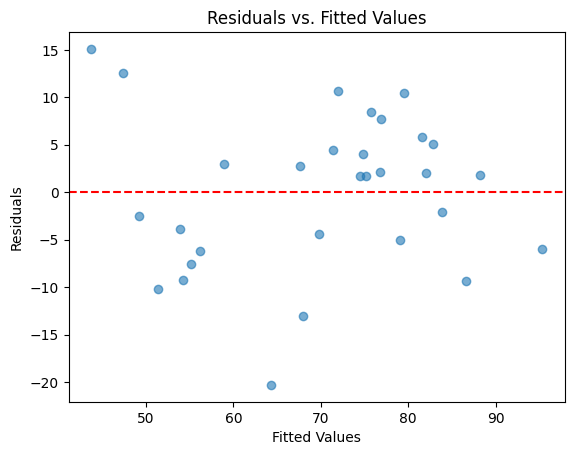

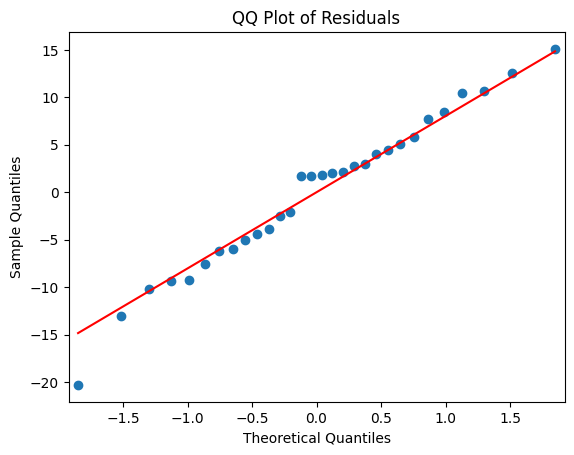

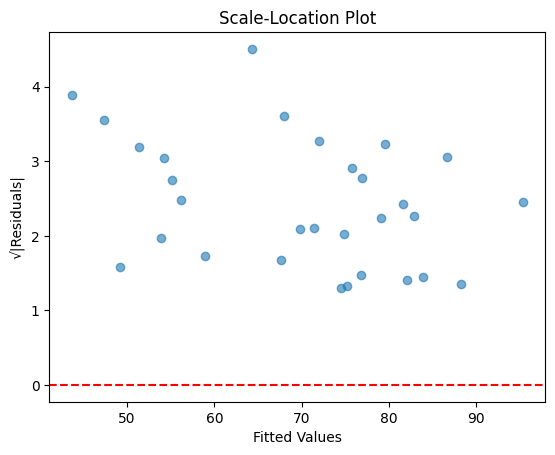

In [70]:
ocean_mixedlm(oceanography_data, target_data, ["fe", "ph", "spco2"])